<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #2


#### Tutorial 2.4: Parameter estimation on GW150914 using open data.

This example estimates the non-spinning parameters of the binary black hole system using
commonly used prior distributions. This will take about 40 minutes to run.
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2019/blob/master/Day_2/Tuto_2.4_Parameter_estimation_for_compact_object_mergers.ipynb)

More examples at https://lscsoft.docs.ligo.org/bilby/examples.html


##  Installation  (execute only if running on a cloud platform!)

In [ ]:
# -- Use the following line in Google Colab
! pip install -q 'lalsuite==6.66' 'bilby==0.6.3' 'gwpy==1.0.1'

     |████████████████████████████████| 28.5 MB 66 kB/s 
     |████████████████████████████████| 1.5 MB 65.5 MB/s 
     |████████████████████████████████| 1.4 MB 54.1 MB/s 
     |████████████████████████████████| 1.6 MB 65.3 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 87 kB 7.8 MB/s 
     |████████████████████████████████| 45 kB 4.1 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 3.2 MB 85.2 MB/s 


**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

/usr/local/lib/python3.7/dist-packages/bilby/core/utils.py:966: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use(backend, warn=False)


Selecting the event, let's pick GW150914.

In [ ]:
label = 'GW150914'
time_of_event = bilby.gw.utils.get_event_time(label)

Here we import the detector data. This step downloads data from the
LIGO/Virgo open data archives. The data is saved to an `Interferometer`
object (here called `H1` and `L1`). A Power Spectral Density (PSD) estimate
is also generated and saved to the same object. To check the data and PSD
makes sense, for each detector a plot is created in the `outdir` called
H1_frequency_domain_data.png and LI_frequency_domain_data.png. The two
objects are then placed into a list.

In this example, we know ahead of time that the maximum frequency of the 
GW150914 signal is aroudn 400Hz, so we can set `filter_freq=1024`.

In [ ]:
interferometers = bilby.gw.detector.get_event_data(label,
                                                   filter_freq=1024,
                                                   outdir='data')

06:23 bilby WARNING : Parameter estimation for real interferometer data in bilby is in alpha testing at the moment: the routines for windowing and filtering have not been reviewed.
06:23 bilby INFO    : Fetching open data from 1126259460.4 to 1126259464.4 with buffer time 0
/usr/local/lib/python3.7/dist-packages/gwpy/types/series.py:926: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  % type(self).__name__)
06:23 bilby INFO    : Saving cache of data to data/H1_1126259460.4_1126259464.4.txt
06:23 bilby INFO    : Fetching open data from 1126258440.4 to 1126258540.4 with buffer time 0
06:23 bilby INFO    : Saving cache of data to data/H1_1126258440.4_1126258540.4.txt
06:23 bilby INFO    : Tukey window PSD data with alpha=0.1, roll off=0.2
06:23 bilby INFO    : Generating frequency domain strain from given time domain strain.
06:23 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2
06:23 bilby WARNING : Parame

### Single parameter analysis

As a start, let's run a short (~1min on a single 2.8GHz core), chirp-mass only parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, and only the chirp-mass is allowed to vary.

In [ ]:
prior = {}
prior['chirp_mass'] = Uniform(name='chirp_mass',latex_label='$M$',minimum=25.0,maximum=35.0,unit='$M_{\\odot}$')
prior['mass_ratio'] = 0.977647
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066
prior['phase'] =  5.30408
prior['geocent_time'] = 1126259462.4146729

In this step we define a `waveform_generator`. This is our object which
creates the frequency-domain strain. In this instance, we are using the
`lal_binary_black_hole model` source model. We also pass other parameters:
the waveform approximant and reference frequency.

In [ ]:
waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',reference_frequency=100.)

waveform_generator = bilby.gw.WaveformGenerator(frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                waveform_arguments=waveform_arguments,
                                                parameter_conversion=convert_to_lal_binary_black_hole_parameters)

In this step, we define the likelihood. Here we use the standard likelihood function, passing it the data and the waveform generator.

In [ ]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers,
                                                            waveform_generator,
                                                            priors=prior)

06:28 bilby WARNING : The waveform_generator start_time is not equal to that of the provided interferometers. Overwriting the waveform_generator.


Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.

In [ ]:
result_mc = bilby.run_sampler(likelihood,
                              prior,
                              sampler='dynesty',
                              outdir='short_mc_only',
                              walks=5,
                              nlive=50,
                              label=label)

06:31 bilby INFO    : Running for label 'GW150914', output will be saved to 'short_mc_only'
06:31 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
06:31 bilby INFO    : Search parameters:
06:31 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
06:31 bilby INFO    :   mass_ratio = 0.977647
06:31 bilby INFO    :   a_1 = 0.0
06:31 bilby INFO    :   a_2 = 0.0
06:31 bilby INFO    :   tilt_1 = 0.0
06:31 bilby INFO    :   tilt_2 = 0.0
06:31 bilby INFO    :   phi_12 = 0.0
06:31 bilby INFO    :   phi_jl = 0.0
06:31 bilby INFO    :   dec = -1.2232
06:31 bilby INFO    :   ra = 2.19432
06:31 bilby INFO    :   theta_jn = 1.89694
06:31 bilby INFO    :   psi = 0.532268
06:31 bilby INFO    :   luminosity_distance = 412.066
06:31 bilby INFO    :   phase = 5.30408
06:31 bilby I

0it [00:00, ?it/s]

06:31 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 50, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 30, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd603899d50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
06:31 bilby INFO    : Checkpoint every n_check_point = 50000
06:31 bilby INFO    : Using dynesty version 1.1
06:31 bilby INFO    : Using the bilby-implemented rwalk sample metho

297it [01:00,  3.16it/s, bound:60 nc:25 ncall:4800 eff:6.2% logz-ratio=289.39+/-0.35 dlogz:0.102>0.10]

06:32 bilby INFO    : Writing checkpoint file short_mc_only/GW150914_resume.pickle



297it [01:00,  4.92it/s, bound:60 nc:1 ncall:4800 eff:7.2% logz-ratio=289.49+/-0.34 dlogz:0.002>0.10] 

06:32 bilby INFO    : Sampling time: 0:00:59.327489
06:32 bilby INFO    : Summary of results:
nsamples: 347
log_noise_evidence: -1194277.730
log_evidence: -1193988.243 +/-  0.340
log_bayes_factor: 289.487 +/-  0.340



We can plot histograms of the samples, getting an approximation of the posterior density function:

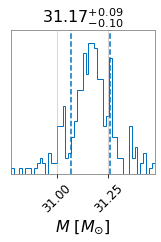

In [ ]:
result_mc.plot_corner()

### More complex analysis

Now that we have run PE in this simple example, we can look at increasing the number of free parameters in our model. We can start from one of the default prior distribution defined in [files](https://git.ligo.org/lscsoft/bilby/tree/master/bilby/gw/prior_files) packaged with Bilby. The prior is printed to the terminal at run-time.

In [ ]:
prior = bilby.gw.prior.BBHPriorDict(filename='GW150914.prior')

We can modify this preset prior either in the prior file itself or at runtime as demonstrated in this example. To speed-up the analysis, let's run with a simpler, non-spinning model, i.e. fixing the spin parameters to zero by providing a float value:

In [ ]:
prior['a_1']=0.0
prior['a_2']=0.0
prior['tilt_1']=0.0
prior['tilt_2']=0.0
prior['phi_12']=0.0
prior['phi_jl']=0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['chirp_mass'] = Uniform(name='chirp_mass',latex_label='$M$',minimum=25.0,maximum=35.0,unit='$M_{\\odot}$')

We could use the likelihood from earlier. But instead lets redefine the likelihood so we can ask it to *marginalise* over the parameters it knows how: `time`, `distance` and `phase`. (Building the lookup table for distance marginalisation can take a few minutes, ~3min on a single 2.8GHz core).

In [ ]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers,
                                                            waveform_generator, 
                                                            time_marginalization=True,
                                                            distance_marginalization=True,
                                                            phase_marginalization=True,
                                                            priors=prior)

06:35 bilby WARNING : Prior not provided for geocent_time, using the BBH default.
06:35 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
06:35 bilby INFO    : Building lookup table for distance marginalisation.


Finally, we run the sampler. This is a slower analysis (~20min for sampling, ~10min of parameter reconstruction on a single 2.8Ghz core).

In [ ]:
result = bilby.run_sampler(likelihood,
                           prior, 
                           sampler='dynesty',
                           outdir='complete', 
                           walks=10,
                           nlive=100,
                           label=label, 
                           dlogz = 1.0,
                           conversion_function=generate_all_bbh_parameters)

06:40 bilby INFO    : Running for label 'GW150914', output will be saved to 'complete'
06:40 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.66;Id: 04a60e3ac9b6ecb285cf96d1137c6a62a3d5cfde;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
06:40 bilby INFO    : Search parameters:
06:40 bilby INFO    :   mass_ratio = Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary='reflective')
06:40 bilby INFO    :   chirp_mass = Uniform(minimum=25.0, maximum=35.0, name='chirp_mass', latex_label='$M$', unit='$M_{\\odot}$', boundary=None)
06:40 bilby INFO    :   theta_jn = Sine(name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, minimum=0, maximum=3.141592653589793, boundary='reflective')
06:40 bilby INFO    :   psi = Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_label='$\\psi$', unit=None, boundary='periodic')
06:40 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.00024

0it [00:00, ?it/s]

06:40 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fd5f777d990>>, 'dlogz': 1.0, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
06:40 bilby INFO    : Checkpoint every n_check_point = 40000
06:40 bilby INFO    : Using dynesty version 1.1
06:40 bilby INFO    : Using the bilby-implemented rwalk sample met

604it [04:44,  1.14it/s, bound:147 nc:54 ncall:18099 eff:3.3% logz-ratio=285.78+/-0.28 dlogz:1.008>1.00]

06:45 bilby INFO    : Writing checkpoint file complete/GW150914_resume.pickle



604it [04:45,  2.11it/s, bound:147 nc:1 ncall:18099 eff:3.9% logz-ratio=286.40+/-0.34 dlogz:0.009>1.00] 

06:45 bilby INFO    : Sampling time: 0:04:42.749846
06:45 bilby INFO    : Reconstructing marginalised parameters.




100%|██████████| 704/704 [00:50<00:00, 14.05it/s]


06:45 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 704/704 [00:09<00:00, 71.48it/s]


06:46 bilby INFO    : Summary of results:
nsamples: 704
log_noise_evidence: -1194277.730
log_evidence: -1193991.331 +/-  0.336
log_bayes_factor: 286.399 +/-  0.336



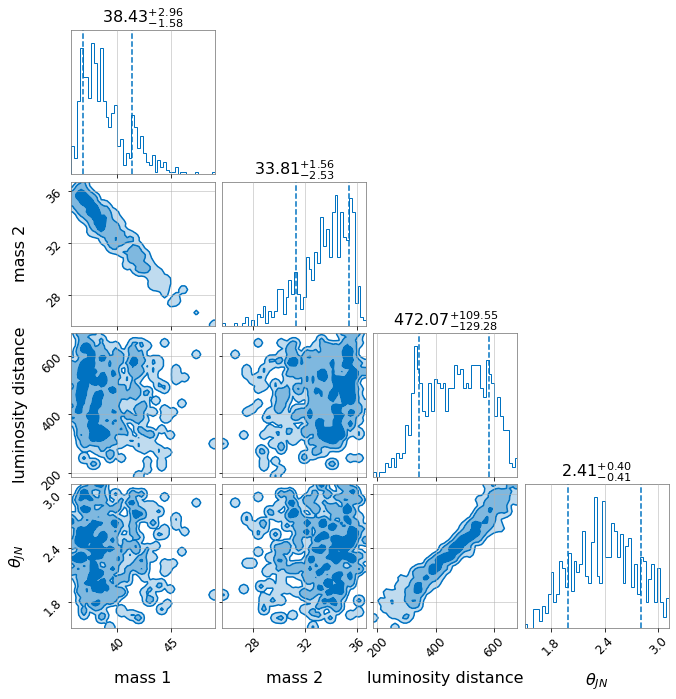

In [ ]:
result.plot_corner(parameters=['mass_1','mass_2','luminosity_distance','theta_jn'])

You can also manually plot the results:

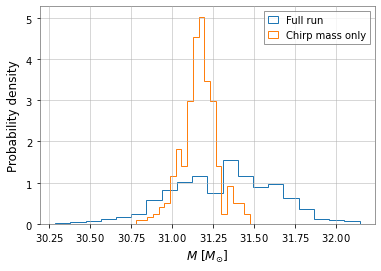

In [ ]:
%matplotlib inline
plt.hist(result.posterior['chirp_mass'],bins=20,histtype='step',density=True,label='Full run')
plt.hist(result_mc.posterior['chirp_mass'],bins=20,histtype='step',density=True,label='Chirp mass only')
plt.ylabel('Probability density')
plt.xlabel('$M~[M_{\\odot}]$')
plt.legend();